# Import Libraries

In [1]:
import torch, torchvision
print(torch.__version__,torch.cuda.is_available())

import matplotlib.pyplot as plt
import cv2
from imutils.object_detection import non_max_suppression
from mmocr.apis import MMOCRInferencer

from craft_text_detector import Craft
import matplotlib.pyplot as plt
import os
import pytesseract
import numpy as np
from datetime import datetime

import ultralytics
from ultralytics import YOLO
ultralytics.checks()

import imutils

import glob
import  traceback

Ultralytics YOLOv8.0.132  Python-3.8.17 torch-2.0.1 CUDA:0 (NVIDIA GeForce GTX 960M, 4096MiB)
Setup complete  (8 CPUs, 15.8 GB RAM, 173.8/238.5 GB disk)


In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Load Detection Model

In [3]:
model = YOLO('best.pt')

# MMOCR

In [4]:
mmocr = MMOCRInferencer(det='TextSnake')

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmocr/textdet/textsnake/textsnake_resnet50-oclip_fpn-unet_1200e_ctw1500/textsnake_resnet50-oclip_fpn-unet_1200e_ctw1500_20221101_134814-a216e5b2.pth
08/17 11:39:35 - mmengine - WARNING - Failed to search registry with scope "mmocr" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmocr" is a correct scope, or whether the registry is initialized.


c:\Users\Ghost\anaconda3\envs\galli_maps\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


# Tesseract

In [5]:
pytesseract.pytesseract.tesseract_cmd = r'C://Program Files//Tesseract-OCR//tesseract.exe'

os.environ["TESSDATA_PREFIX"] =  "C://Program Files//Tesseract-OCR//tessdata"
custom_config = r'-c preserve_interword_spaces=5 --oem 3 --psm 8 '

# Craft Module

In [6]:
class CraftModule:
    def __init__(self,craft,mmocr):
        self.craft = craft
        self.mmocr = mmocr
        self.boxes = None
        self.image = None
    
    def plot_image(self,img):
        plt.axis('off');
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));
        plt.show();
    
    def angle_with_x_axis(self,contour):
        # Extract the first and last points of the contour
        first_point = contour[0]
        last_point = contour[-1]

        # Calculate the cross product between the vector and the positive x-axis
        cross_product = np.cross(last_point, first_point)

        if cross_product > 0:
            # The contour makes a counterclockwise angle with the x-axis.
            return 0
        elif cross_product < 0:
            # The contour makes a clockwise angle with the x-axis.
            return 1
        else:
            # The contour is aligned with the x-axis.
            return None

    def rotate_image(self):
        img = self.image.copy()
        det = self.mmocr(self.image)
        boxes = det['predictions'][0]['det_polygons']
        angled_boxes = []

        # Get angled boxes
        for box in boxes:
            if len(box) >= 3:  # Ensure at least 3 points for a polygon
                # Convert box points to numpy array for easier manipulation
                box_points = np.array(box, dtype=np.int32).reshape(-1, 2)

                # Calculate the minimum bounding rectangle
                rotated_rect = cv2.minAreaRect(box_points)
                box_vertices = cv2.boxPoints(rotated_rect)
                box_vertices = np.int0(box_vertices)
                angled_boxes.append(box_vertices)
                cv2.drawContours(img, [box_vertices], 0, (255, 0, 0), 2)
        plt.imshow(img)

        # Get largest contour and rotate on basis of that
        largest_contour = max(angled_boxes, key=cv2.contourArea)
        
        rectangle_points = largest_contour
        # Choose two points to calculate the slope
        x1, y1 = rectangle_points[0]
        x2, y2 = rectangle_points[1]
        if x2 - x1 != 0:
            # Calculate the slope (tangent) of the rectangle's side with respect to the x-axis
            slope = (y2 - y1) / (x2 - x1)

            # Calculate the angle in degrees using the arctangent function
            angle_radians = np.arctan(slope)
            angle_degrees = np.degrees(angle_radians)
        else:
            angle_degrees = 90
        # Calculate the angle in degrees using the arctangent function
        _,_,angle = cv2.minAreaRect(largest_contour)
        
        if angle_degrees < 0 and self.angle_with_x_axis(largest_contour):
            angle = angle_degrees

        height, width = img.shape[:2]
        center = (width // 2, height // 2)
        
        if angle_degrees != 90:
            rotation_matrix = cv2.getRotationMatrix2D(center, angle , scale=1.0)
            self.image = cv2.warpAffine(self.image, rotation_matrix , (width, height))   

    def detect_text(self,image):
        self.image = image.copy()
        self.plot_image(image)
        self.rotate_image()
        self.boxes = self.craft.detect_text(self.image)['boxes']
        self.plot_image(self.image)
        print('------------ Detected Text Regions ------------')
        self.draw_rectangles()
        # print('------------ Croped Text Regions ------------')
        self.show_cropped_image()

    def get_bounding_boxes(self,box):
        flat_box = box.flatten()
        x_min = round(min([flat_box[x] for x in [0,2,4,6]]))
        y_min = round(min([flat_box[y] for y in [1,3,5,7]]))
        x_max = round(max([flat_box[x] for x in [0,2,4,6]]))
        y_max = round(max([flat_box[y] for y in [1,3,5,7]]))

        return x_min,y_min,x_max,y_max
    
    def draw_rectangles(self):
        image_rect = self.image.copy()
        for box in self.boxes:
            x_min,y_min,x_max,y_max = self.get_bounding_boxes(box)
            image_rect = cv2.rectangle(image_rect, (x_min,y_min), (x_max,y_max), (255,0,0), 2)
        self.plot_image(image_rect)
            
    def show_cropped_image(self):
        for box in self.boxes:
            x_min,y_min,x_max,y_max = self.get_bounding_boxes(box)
            roi = self.image[y_min : y_max , x_min : x_max].copy()
            roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
            roi_invert = cv2.bitwise_not(roi_gray)
            thresh = cv2.threshold(roi_gray, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
            edges = cv2.Canny(roi, 27, 255)
            self.plot_image(roi_gray)
            # self.plot_image(cv2.bitwise_not(roi_gray))


            # contour, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
            # print(len(contour))
            
            # text_english_t = pytesseract.image_to_string(thresh,lang = 'eng', config = custom_config)
            # text_nepali_t = pytesseract.image_to_string(thresh,lang = 'nep', config = custom_config)
            # text_nepali_hin_t = pytesseract.image_to_string(thresh,lang = 'nep+hin', config = custom_config)


            text_english = pytesseract.image_to_string(roi_invert,lang = 'eng', config = custom_config)
            text_nepali = pytesseract.image_to_string(roi_invert,lang = 'nep', config = custom_config)
            text_nepali_hin = pytesseract.image_to_string(roi_invert,lang = 'nep+hin', config = custom_config)


            print(f'English (gray) : {text_english}')
            print(f'Nepali (gray) : {text_nepali}')
            print(f'Nepali + Hindi (gray) : {text_nepali_hin}')

            # print(f'English (thresh) : {text_english_t}')
            # print(f'Nepali (thresh) : {text_nepali_t}')
            # print(f'Nepali + Hindi (thresh) : {text_nepali_hin_t}')

            now_time=datetime.now()
            current_time = now_time.strftime("%d_%m_%Y_%H_%M_%S")
            cv2.imwrite(f'results/{current_time}.jpg',roi)
            
            with open(f'results/{current_time}.txt', "w") as file:
                file.write(f'English : {text_english}\n')
                file.write(f'Nepali : {text_nepali}\n')
                file.write(f'Nepali + Hindi : {text_nepali_hin}\n')

            # self.plot_image(roi)
    

In [7]:
craft = Craft( crop_type="box", cuda=True,text_threshold=0.8,link_threshold=0.8,low_text=0.18)

c:\Users\Ghost\anaconda3\envs\galli_maps\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ghost\anaconda3\envs\galli_maps\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Read Images

In [8]:
file_type=['JPG','JPEG','PNG','JFIF']
images=[]
#for copying later
filename=[]
for format in file_type:
    for path in glob.glob(f"testing2/*.{format}"):
        filename.append(path)
        images.append(cv2.imread(path))

Inference ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   

Traceback (most recent call last):
  File "C:\Users\Ghost\AppData\Local\Temp\ipykernel_3760\78448589.py", line 10, in <module>
    CraftModule(craft,mmocr).detect_text(roi)
  File "C:\Users\Ghost\AppData\Local\Temp\ipykernel_3760\331941052.py", line 83, in detect_text
    self.rotate_image()
  File "C:\Users\Ghost\AppData\Local\Temp\ipykernel_3760\331941052.py", line 52, in rotate_image
    largest_contour = max(angled_boxes, key=cv2.contourArea)
ValueError: max() arg is an empty sequence
Traceback (most recent call last):
  File "C:\Users\Ghost\AppData\Local\Temp\ipykernel_3760\78448589.py", line 10, in <module>
    CraftModule(craft,mmocr).detect_text(roi)
  File "C:\Users\Ghost\AppData\Local\Temp\ipykernel_3760\331941052.py", line 83, in detect_text
    self.rotate_image()
  File "C:\Users\Ghost\AppData\Local\Temp\ipykernel_3760\331941052.py", line 52, in rotate_image
    largest_contour = max(angled_boxes, key=cv2.contourArea)
ValueError: max() arg is an empty sequence


TypeError: write() argument must be str, not None

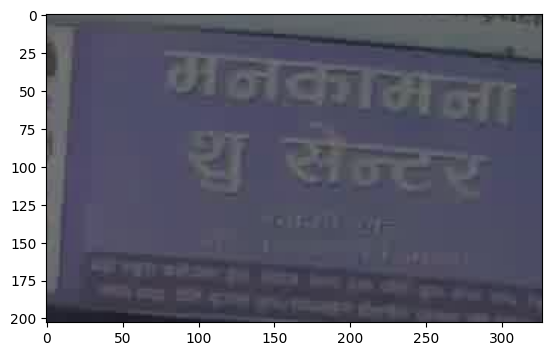

In [9]:
for image in images:
    try:
        detected_boards = model(image)
        detected_boards[0].boxes.data = torch.stack([box for box in detected_boards[0].boxes.data])
        boxes = detected_boards[0].boxes.data
        for box in boxes:
            x1,y1,x2,y2 = int(box[0]),int(box[1]),int(box[2]),int(box[3])

            roi =  image[y1 : y2, x1 : x2]
            CraftModule(craft,mmocr).detect_text(roi)
    except Exception:
        traceback.print_exc()
        
        with open('errors/text.txt','a') as f:
            f.write(traceback.print_exc())